In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


RMSE: 2.81
R² Score: 0.71
MAE: 1.97
Explained Variance Score: 0.71


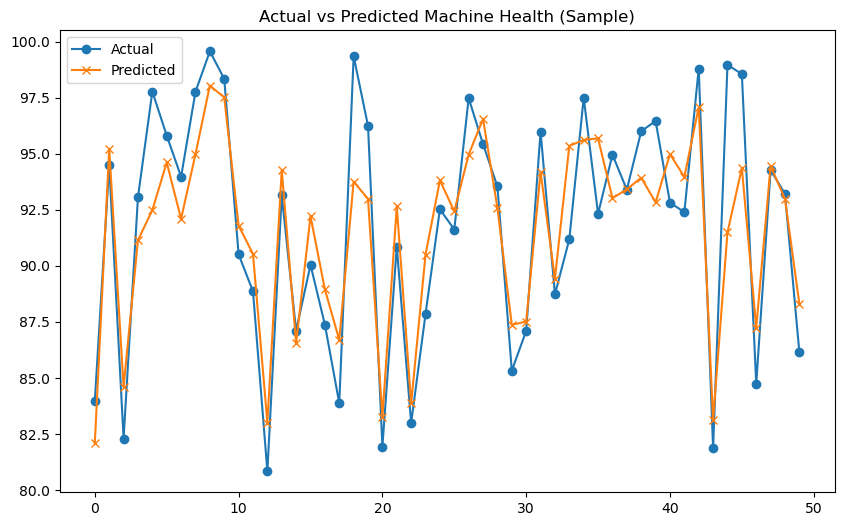


Top 5 Most Important Features:
                 feature  importance
2            noise_level    0.247202
7  temperature_7day_mean    0.229021
0            temperature    0.199785
9  noise_level_7day_mean    0.189465
1              vibration    0.032938


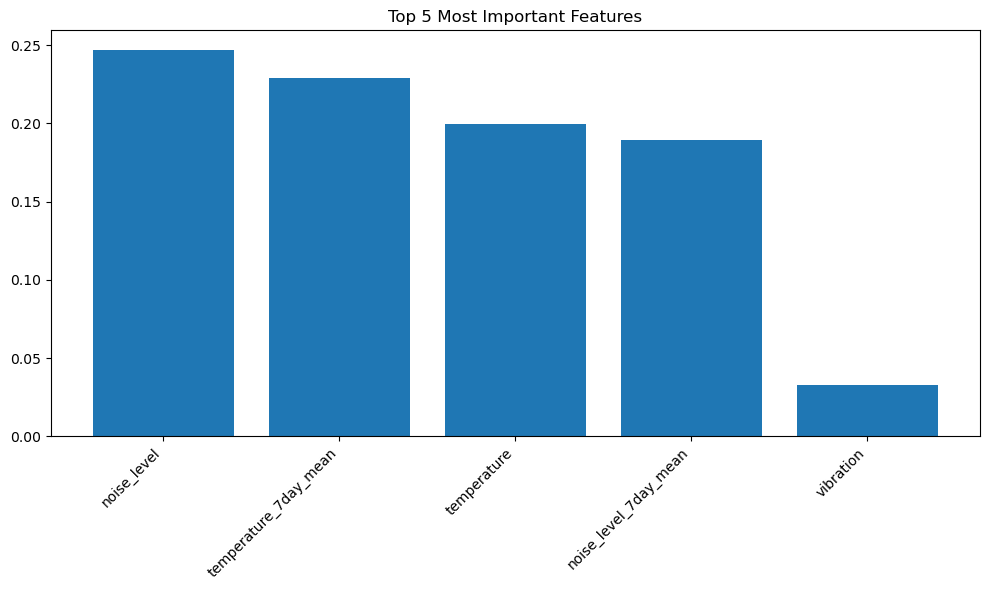

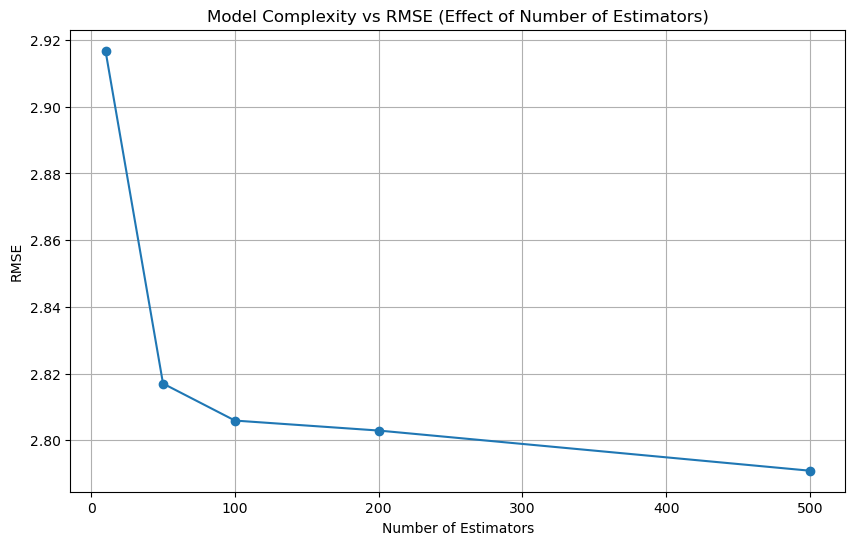

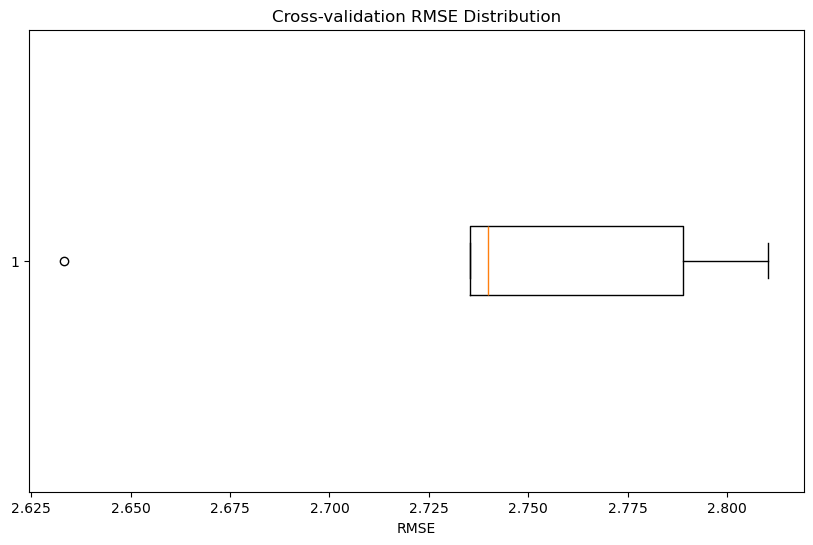


Model Performance:
RMSE: 2.79
R² Score: 0.71
MAE: 1.97
Explained Variance Score: 0.71

Top 5 Most Important Features:
                 feature  importance
2            noise_level    0.247202
7  temperature_7day_mean    0.229021
0            temperature    0.199785
9  noise_level_7day_mean    0.189465
1              vibration    0.032938


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def prepare_and_train_model(data_path):
    """
    Prepare data and train model for maintenance prediction using Random Forest
    """
    # Read the data
    df = pd.read_csv(data_path)
    
    # Convert timestamp to datetime and extract features
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['day_of_month'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    
    # Rolling window features for sensors
    sensors = ['temperature', 'vibration', 'noise_level']
    for sensor in sensors:
        df[f'{sensor}_7day_mean'] = df.groupby('machine_id')[sensor].rolling(7, min_periods=1).mean().reset_index(0, drop=True)
        df[f'{sensor}_change'] = df.groupby('machine_id')[sensor].diff()
    
    # Encode machine type
    le = LabelEncoder()
    df['machine_type_encoded'] = le.fit_transform(df['machine_type'])
    
    # Define features for training
    feature_columns = [
        'temperature', 'vibration', 'noise_level', 'hours_run', 
        'machine_type_encoded', 'day_of_month', 'month',
        'temperature_7day_mean', 'vibration_7day_mean', 'noise_level_7day_mean'
    ]
    
    df = df.dropna(subset=feature_columns + ['machine_health'])
    
    # Prepare input (X) and output (y) data
    X = df[feature_columns]
    y = df['machine_health']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train the model using RandomForestRegressor
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = rf_model.predict(X_test_scaled)
    
    # Performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)
    
    # Display performance metrics
    print(f"RMSE: {rmse:.2f}")
    print(f"R² Score: {r2:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"Explained Variance Score: {evs:.2f}")
    
    # Plot Actual vs Predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values[:50], label='Actual', marker='o')
    plt.plot(y_pred[:50], label='Predicted', marker='x')
    plt.legend()
    plt.title('Actual vs Predicted Machine Health (Sample)')
    plt.show()
    
    # Get feature importance from RandomForestRegressor model
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Top 5 most important features
    top_5_features = feature_importance.head(5)
    print("\nTop 5 Most Important Features:")
    print(top_5_features)
    
    # Plot top 5 most important features
    plt.figure(figsize=(10, 6))
    plt.bar(top_5_features['feature'], top_5_features['importance'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 5 Most Important Features')
    plt.tight_layout()
    plt.show()

    # --- Plot Model Complexity vs Performance ---
    n_estimators_range = [10, 50, 100, 200, 500]
    rmse_list = []
    
    for n_estimators in n_estimators_range:
        rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
        rf_model.fit(X_train_scaled, y_train)
        y_pred = rf_model.predict(X_test_scaled)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
    
    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, rmse_list, marker='o')
    plt.xlabel('Number of Estimators')
    plt.ylabel('RMSE')
    plt.title('Model Complexity vs RMSE (Effect of Number of Estimators)')
    plt.grid(True)
    plt.show()
    
    # --- Plot Cross-validation Results (Robustness) ---
    cross_val_rmse = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')
    plt.figure(figsize=(10, 6))
    plt.boxplot(-cross_val_rmse, vert=False)
    plt.title('Cross-validation RMSE Distribution')
    plt.xlabel('RMSE')
    plt.show()

    return {
        'model': rf_model,
        'scaler': scaler,
        'label_encoder': le,
        'metrics': {
            'rmse': rmse,
            'r2': r2,
            'mae': mae,
            'explained_variance_score': evs
        },
        'top_5_features': top_5_features
    }

# Example usage
if __name__ == "__main__":
    model_results = prepare_and_train_model('maintenance_data.csv')
    
    print("\nModel Performance:")
    print(f"RMSE: {model_results['metrics']['rmse']:.2f}")
    print(f"R² Score: {model_results['metrics']['r2']:.2f}")
    print(f"MAE: {model_results['metrics']['mae']:.2f}")
    print(f"Explained Variance Score: {model_results['metrics']['explained_variance_score']:.2f}")
    
    print("\nTop 5 Most Important Features:")
    print(model_results['top_5_features'])
